![title](icon_3.png)

In [1]:
# Import libraries

import pandas as pd             #Dataframe
import sqlite3                  #Database
import matplotlib.pyplot as plt #Visualization
import seaborn as sns           # Visualization
import numpy as np              #Numeric analysis
import datetime                 #Dealing with time
%matplotlib inline              

In [2]:
# set option, change the rows and cols max display 
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)

In [3]:
#Establishing connection to the database
conn = sqlite3.connect('financial.db')
c = conn.cursor()
for row in c.execute('SELECT * FROM Account LIMIT 5'):
    print(row)


(1, 18, 'POPLATEK MESICNE', '1995-03-24')
(2, 1, 'POPLATEK MESICNE', '1993-02-26')
(3, 5, 'POPLATEK MESICNE', '1997-07-07')
(4, 12, 'POPLATEK MESICNE', '1996-02-21')
(5, 15, 'POPLATEK MESICNE', '1997-05-30')


Looks good. We can go on with the analysis.

In [4]:
#Checking the tables in the database
def sql_fetch(conn):
    cursor = conn.cursor()
    cursor.execute('SELECT name from sqlite_master where type= "table"')
    print(cursor.fetchall())

sql_fetch(conn)

[('account',), ('card',), ('client',), ('disp',), ('district',), ('loan',), ('order',), ('trans',)]


Looks like we have 8 tables in our database.

# Account

In [5]:
# Querying data from the Account table
query = "SELECT * FROM Account;"

#Reading the query result as a dataframe
data_account = pd.read_sql_query(query,conn)
data_account.head()

,account_id,district_id,frequency,date
0,1,18,POPLATEK MESICNE,1995-03-24
1,2,1,POPLATEK MESICNE,1993-02-26
2,3,5,POPLATEK MESICNE,1997-07-07
3,4,12,POPLATEK MESICNE,1996-02-21
4,5,15,POPLATEK MESICNE,1997-05-30


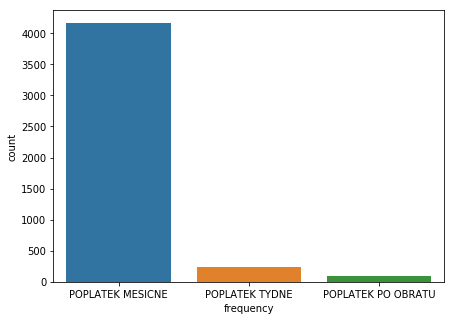

In [6]:
#Looking at the counts of each frequency category
fig, ax =plt.subplots(figsize=(7,5))
sns.countplot(x="frequency", data=data_account)
plt.show()

POPLATEK MESICNE is the predominant issuance. This means that the "Monthly" issuance is the main frequency issuance of statements. "Issuance after transaction" is the least frequent issuance of statements.

# Client 

In [7]:
#Querying data from the Client table.
query = "SELECT * FROM Client;"

#Reading the query result as a dataframe
data_client = pd.read_sql_query(query,conn)
data_client.head()

,client_id,gender,birth_date,district_id
0,1,F,1970-12-13,18
1,2,M,1945-02-04,1
2,3,F,1940-10-09,1
3,4,M,1956-12-01,5
4,5,F,1960-07-03,5


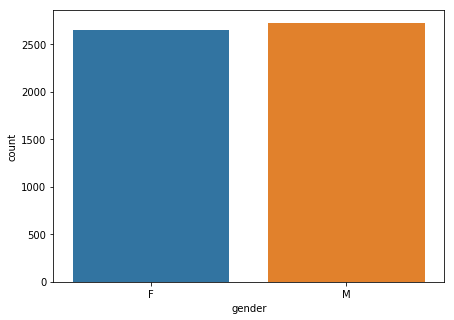

In [8]:
#Looking at the distribution of gender
fig, ax =plt.subplots(figsize=(7,5))
sns.countplot(x="gender", data=data_client)
plt.show()

It does look like there is no gender disparity in the client base of the bank, although men are slightly more than women. 

# Disposition

In [9]:
# Data on disposition -- stored as "disp" in the database.
#Querying data from the Disposition table and then reading the output as a dataframe.

query = "SELECT * FROM disp;"
data_disp = pd.read_sql_query(query,conn)
data_disp.head(2)

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER


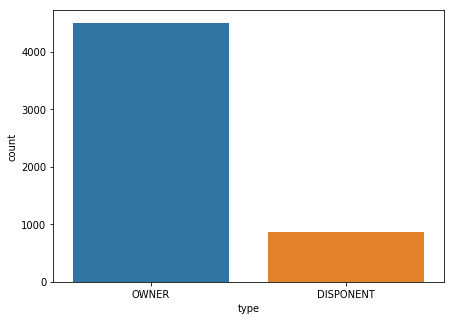

In [10]:
#Looking at the proportions of disposition among clients
fig, ax =plt.subplots(figsize=(7,5))
sns.countplot(x="type", data=data_disp)
plt.show()

Results indicate that there are close to 1000 clients who are not owners -- they are disponents. That means that only owners of accounts (a little over 4,000) can issue permanent orders and ask for a loan.
     

It may be interesting to look at gender disparities in disposition data. That means we can join both the Client table and the Disposition table to see what that tells us about the proportion of clients with regards to both gender and disposition. The first step is to join or merge both tables and the second is to graph the proportions. Both steps are shown below:

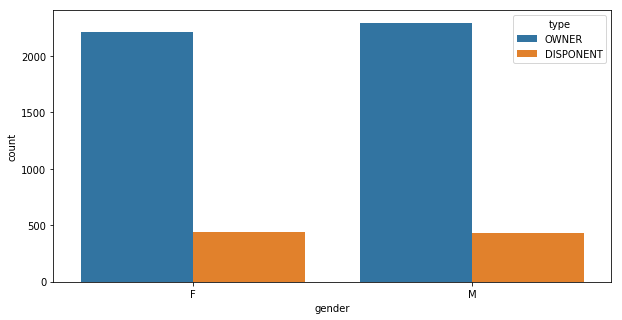

In [11]:
#Step 1: Joining/merging both tables. This merge uses a left join
client_disp = pd.merge(data_client, data_disp, on='client_id', how ='left')
#client_disp.head()

#Step 2: plotting
fig, ax =plt.subplots(figsize=(10,5))
sns.countplot(x="gender", data=client_disp, hue='type')
plt.show()

As was the case for just gender in the Client table, there does not seem to be a gender disparity even among disponents.

# Permanent order

In [12]:
#Querying data from the Order table and then reading the result as a dataframe
# Data on permanent order -- stored as "order" in the database
query = "SELECT * FROM 'order';"
data_order = pd.read_sql_query(query,conn)
#print(data.columns)
data_order.head(2)

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER


Since we have many columns here, it may be good to have a look at some of the statistics of continuous data.

In [13]:
#Summarizing data from the Order table
data_order.describe().round(2)

,order_id,account_id,account_to,amount
count,6471.00,6471.0,6471.00,6471.00
mean,33778.20,2962.3,49399036.85,3280.64
std,3737.68,2518.5,28883559.11,2714.48
min,29401.00,1.0,399.00,1.00
25%,31187.50,1223.0,24159184.00,1241.50
50%,32988.00,2433.0,49756062.00,2596.00
75%,34785.50,3645.5,74000447.50,4613.50
max,46338.00,11362.0,99994199.00,14882.00


The maximum amount of payment is 14,882 while the minimum amount is 1. On average clients pay 3,280 in orders.

This may not tell us much about the distribution of the amount of money paid in orders. To see that, we can look at the distribution of the "amount" variable (See below).

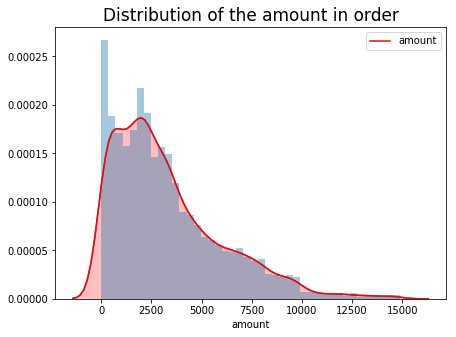

In [14]:
#Plotting the distribution of payments made for orders
fig, ax = plt.subplots(figsize=(7,5))
plt.title("Distribution of the amount in order", fontsize=17)
sns.distplot(data_order['amount'])
sns.kdeplot(data_order['amount'], shade=True, color="r")
plt.show()

The distribution indicates that the majority of orders seem to revolve around 2,500. Very few orders reach 15,000.

How can we find out what are these orders made for or what this money is spent on? We can find out by lookin at the characterization of the payments (see below).

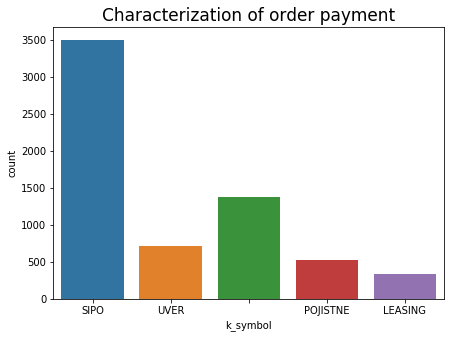

In [15]:
#Plotting the payment characterization
fig, ax =plt.subplots(figsize=(7,5))
plt.title("Characterization of order payment", fontsize=17)
sns.countplot(x="k_symbol", data=data_order)
plt.show()

The majority of the payments are household payments, while leasing is the least paid-for category. There is a fair amount of payments that are not characterized (close to 1,500 payments).


# Transaction

In [16]:
#Querying data fro the Trans table and then reading the data as a dataframe.
#Transaction data -- stored as "trans" in the database
query = "SELECT * FROM trans;"
data_trans = pd.read_sql_query(query,conn)
data_trans.head(2)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1,1,1995-03-24,PRIJEM,VKLAD,1000,1000,None,None,NaN
1,5,1,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,None,AB,41403269.0


In [17]:
#Grouping data (amount) by the characterization of the transaction
grouped_amount = data_trans[['k_symbol','amount']]
grouped_sum = grouped_amount.groupby('k_symbol').sum()

#Using Seaborn to style the resulting table to easily see some the pattern (e.g., higher value, lower value)
cm = sns.light_palette("green", as_cmap=True)
summary = grouped_sum.style.background_gradient(cmap=cm)
summary

,amount
k_symbol,
,108619633
DUCHOD,167472118
POJISTNE,24175193
SANKC. UROK,37736
SIPO,498506416
SLUZBY,2744045
UROK,27479762
UVER,55253001


The grouped summary indicates that the greatest amount in transaction is characterized as "household" transaction (see darker green in the table) while the least amount in transaction is characterized as sanction interest for any negative balance (See light green in the table).

In [18]:
#Grouping data (amount) by the mode of the transaction
grouped_amount = data_trans[['operation','amount']]
grouped_sum = grouped_amount.groupby('operation').sum()

#Using Seaborn to style the resulting table to easily see the pattern (e.g., higher value, lower value)
cm = sns.light_palette("green", as_cmap=True)
summary = grouped_sum.style.background_gradient(cmap='Blues')
summary

,amount
operation,
PREVOD NA UCET,672638484
PREVOD Z UCTU,781479953
VKLAD,2418522949
VYBER,2339570649
VYBER KARTOU,18170400


The results indicate that the credit in cash (VKLAD) is the mode that is mostly used while the credit card withdrawal (VYBER KARTOU) is the least used mode of transaction. 

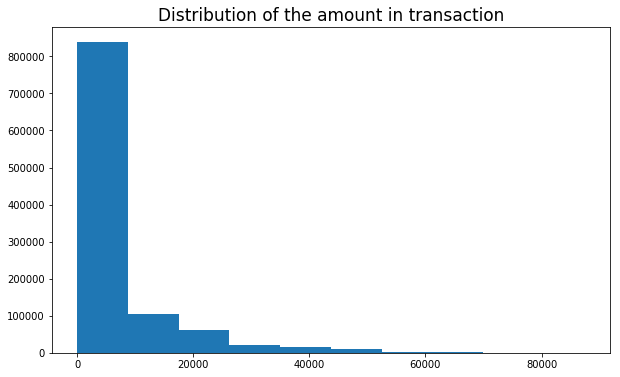

In [19]:
#Plotting the distribution of the amount in transaction.
ax, fig = plt.subplots(figsize=(10,6))
plt.title("Distribution of the amount in transaction", fontsize=17)
plt.hist(data_trans['amount'])
plt.show()

The majority of clients make transactions of between 15,000 and less.

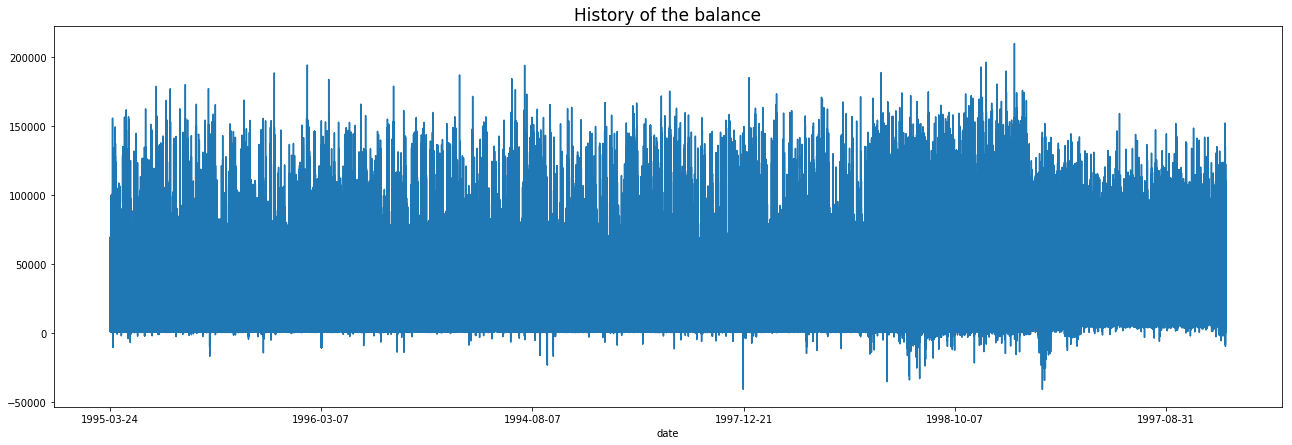

In [20]:
#Looking at the history of transactions -- the balance
#sns.set()
x = data_trans.set_index('date') #Setting the date as the index
x = x['balance']
fig, ax =plt.subplots(figsize=(22,7))
plt.title("History of the balance", fontsize=17)
x.plot()
plt.show()

The histrory of the balance shows that there have been some negative values, indicating that some clients have had in negative balances.

We can see how many by conditionally querying the negative values and then counting them (See below).  

In [21]:
negative_balance = data_trans.query('balance<0')
negative_balance.balance.count()

2999

There are 2,999 clients whose balance was below zero at some point. 

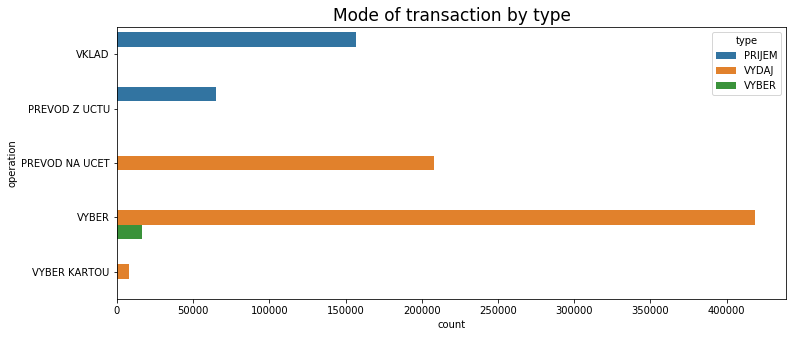

In [22]:
#The operations and their types
fig, ax =plt.subplots(figsize=(12,5))
plt.title("Mode of transaction by type", fontsize=17)
sns.countplot(y="operation",hue='type', data=data_trans)
plt.show()

The most common operation is "Withdraw in cash" (VYBER) followed by "Remittance to another bank" (PREVOD NA UCET). The least common operation is credit card withdrawal, both modes being of withdrawal type (as opposed to credit).


# Loan

In [23]:
#Querying data from the Loan table and then reading the data as a dataframe. 
query = "SELECT * FROM Loan;"
data_loan = pd.read_sql_query(query,conn)
data_loan.head(2)

,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,1994-01-05,80952,24,3373,A
1,4961,19,1996-04-29,30276,12,2523,B


In [24]:
#Describing the data
data_loan.describe()

,loan_id,account_id,amount,duration,payments
count,682.000000,682.000000,682.000000,682.000000,682.000000
mean,6172.466276,5824.162757,151410.175953,36.492669,4190.664223
std,682.579279,3283.512681,113372.406310,17.075219,2215.830344
min,4959.000000,2.000000,4980.000000,12.000000,304.000000
25%,5577.500000,2967.000000,66732.000000,24.000000,2477.000000
50%,6176.500000,5738.500000,116928.000000,36.000000,3934.000000
75%,6752.500000,8686.000000,210654.000000,48.000000,5813.500000
max,7308.000000,11362.000000,590820.000000,60.000000,9910.000000


On average, the amount of money loaned to client is 151,410 while the average amount of payment is 4,190. It takes 3 years on average to pay the loan. The maximum amount of money in loan is 590,820 while the maximum payment so far is 9,910. 

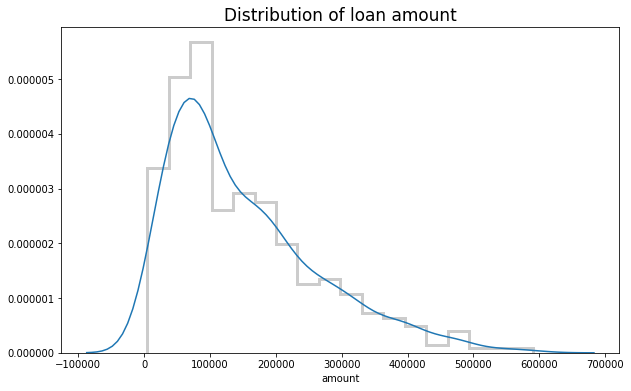

In [25]:
#Looking at the distribution of the aount in loans.
fig,ax =plt.subplots(figsize=(10,6))
plt.title("Distribution of loan amount", fontsize=17)
sns.distplot(data_loan['amount'], hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.2, "color": "k"}, kde = True)
plt.show()

A Kernel Density Estiation (kde) can be used to look at the distribution. 

Most people get more or less 10,000 in loans, while very few get as high as 400,000.

The same resoning can be done with a histogram to look at the distribution with real numbers (not kde) -- see below.

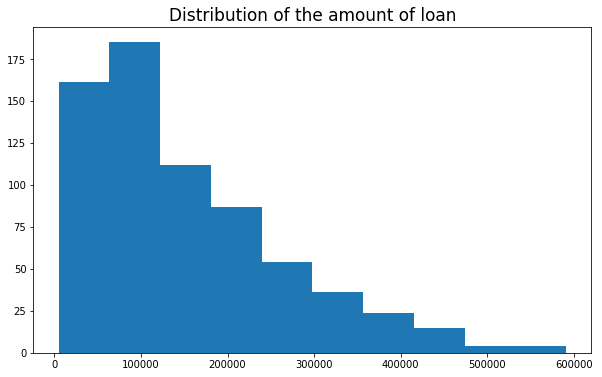

In [26]:
ax, fig = plt.subplots(figsize=(10,6))
plt.title("Distribution of the amount of loan", fontsize=17)
plt.hist(data_loan['amount'])
plt.show()

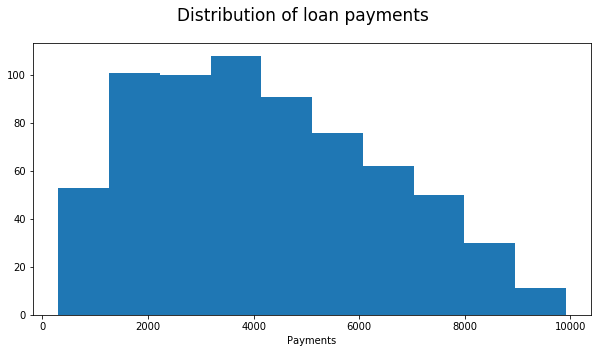

In [27]:
fig, (ax) = plt.subplots(figsize=(10,5))
ax.hist(data_loan['payments'])
ax.set_xlabel('Payments')

_ = fig.suptitle('Distribution of loan payments', fontsize=17)

plt.show()

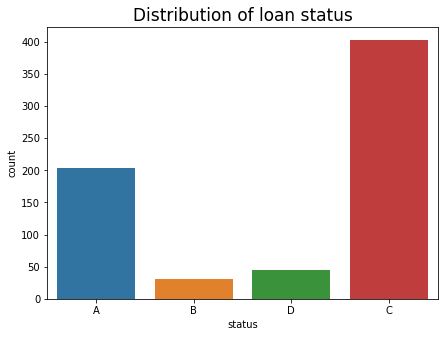

In [28]:
fig, ax =plt.subplots(figsize=(7,5))
plt.title("Distribution of loan status", fontsize=17)
sns.countplot(x="status", data=data_loan)
plt.show()

The majority of clients (around 400 clients) who have loans are in category 'C', which means that they are under contract and are okey so far. Close to 50 clients are in debt (catgory D).

We can also look at how many people are in each category by grouping by status (see below)

In [29]:
#Grouping and counting clients in every category of loan status
grouped_status=data_loan.groupby('status').size()
grouped_status.head()

status
A    203
B     31
C    403
D     45
dtype: int64

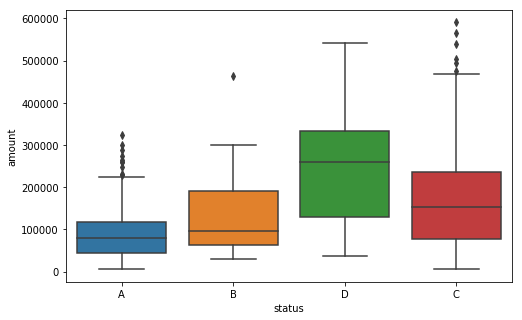

In [30]:
#Looking at the distribution of amount in loan among status groups using boxplots
fig, ax = plt.subplots(figsize = (8,5))
sns.boxplot(x=data_loan['status'], y=data_loan['amount'], data=data_loan )
plt.show()

Data indicate that there are more outliers in both status A and C than others. 

# Credit card

In [31]:
#Querying data from the Card table and then reading it as a dataframe.
#Data on credit card -- stored as "card" in the database
query = "SELECT * FROM card;"
data_card = pd.read_sql_query(query,conn)
data_card.head()

,card_id,disp_id,type,issued
0,1,9,gold,1998-10-16
1,2,19,classic,1998-03-13
2,3,41,gold,1995-09-03
3,4,42,classic,1998-11-26
4,5,51,junior,1995-04-24


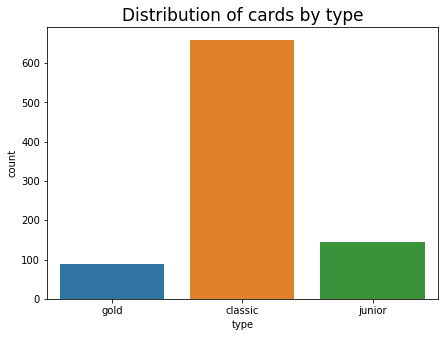

In [32]:
#Looking at the distribution of the type of cards are given to clients
fig, ax =plt.subplots(figsize=(7,5))
plt.title("Distribution of cards by type", fontsize=17)
sns.countplot(x="type", data=data_card)
plt.show()

Over 600 clients have a 'classic' type of card while nearly 100 have 'gold' and close to 200 have 'junior' types of cards.

# District

In [33]:
#Querying data from the District table and reading it as a dataframe.
#Demographic data -- stored as "district" in the database
query = "SELECT * FROM district;"
data_district = pd.read_sql_query(query,conn)
data_district.head(2)

,district_id,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.6,1.85,132,2159.0,2674


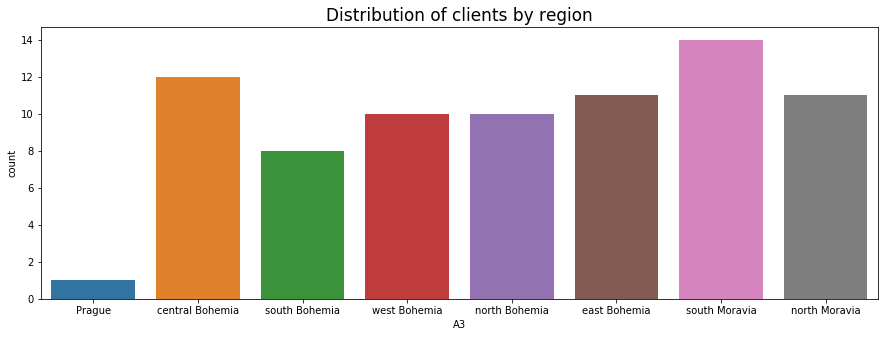

In [34]:
#Looking at the distribution of clients and the regions where they live in.
fig, ax =plt.subplots(figsize=(15,5))
plt.title("Distribution of clients by region", fontsize=17)
sns.countplot(x="A3", data=data_district)
plt.show()

The region with the most districts is South Moravia, followed by Central Bohemia

# Merging/Joining some more tables for more insights

Joining transaction and loan tables

In [35]:
#Joining transaction with loan - Using a left join
loan_trans = pd.merge(data_loan, data_trans, on='account_id', how='left')
loan_trans.head(3)

,loan_id,account_id,date_x,amount_x,duration,payments,status,trans_id,date_y,type,operation,amount_y,balance,k_symbol,bank,account
0,4959,2,1994-01-05,80952,24,3373,A,276,1993-02-26,PRIJEM,VKLAD,1100,1100,None,None,NaN
1,4959,2,1994-01-05,80952,24,3373,A,279,1993-03-12,PRIJEM,PREVOD Z UCTU,20236,21336,None,ST,66487163.0
2,4959,2,1994-01-05,80952,24,3373,A,280,1993-04-12,PRIJEM,PREVOD Z UCTU,20236,45286,None,ST,66487163.0


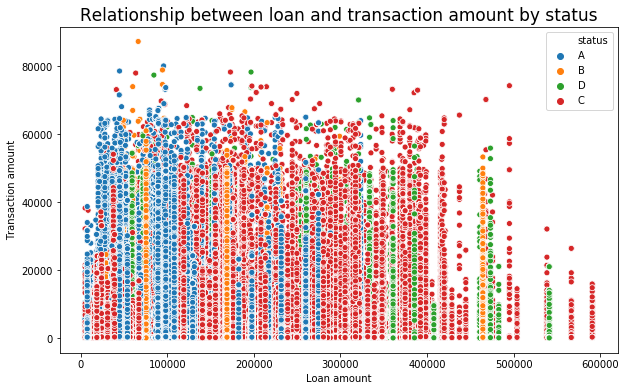

In [36]:
#Plotting the relationship between loan and transaction amounts
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Relationship between loan and transaction amount by status", fontsize=17)
loan_amount=loan_trans['amount_x']
trans_amount=loan_trans['amount_y']
sns.scatterplot(x=loan_amount,y=trans_amount, data=loan_trans, hue='status')
plt.xlabel('Loan amount')
plt.ylabel('Transaction amount')
plt.show()

There is no clear relationship between the amount of money a client is loaned and the amount of the transaction they make. However, there seems to be a small downward tendency for clients who are doing okay in their loan to have less amount in transaction as they amount of loan increases. this may indicate that the more loan you get the more cautious you become in spending, thus less transaction. 

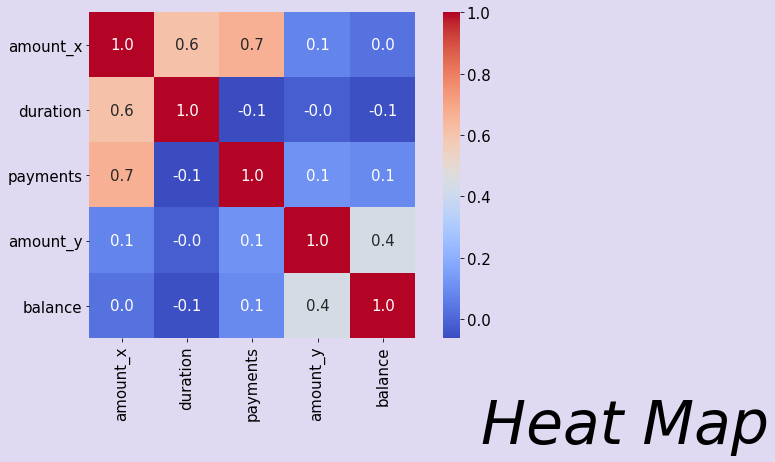

In [37]:
# #correlation on the joined loan-transaction data
plt.rcParams['font.size'] = 15
bg_color = (0.88,0.85,0.95)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

fig, ax = plt.subplots(figsize=(10,6))

data = loan_trans[['amount_x','duration', 'payments','amount_y', 'balance']]
corr = data.corr()
sns.heatmap(corr, 
            cmap='coolwarm',
            fmt='.1f',
            annot_kws={'size':15},
            square=True,
            annot=True,
           ax=ax)
plt.text(6,6.6, "Heat Map", fontsize = 60, color='Black', fontstyle='italic')
plt.show()

The correlation map indicates that there is a positive relationship between the balance after getting a loan (balance) and the loan amount (amount_x). Additionally, there is a negative relationship between the transaction amount (amount_y) and the duration/time. Another strong relationship is between the loan amount (amount_x) and the amount in payments. 

In [38]:
#Closing the database
conn.close()